<a href="https://colab.research.google.com/github/fabricemlili/Supervised-learning/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Dense, Flatten, Bidirectional, LSTM
from tensorflow.keras import Sequential
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
!pip install pydub
from IPython.display import clear_output
from scipy.io.wavfile import write, read
from IPython.display import Audio

clear_output(wait=False)

In [44]:
ds, info = tfds.load('crema_d', with_info=True, as_supervised=True)
clear_output(wait=False)
print(ds)

{'train': <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'validation': <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [45]:
tfds.as_dataframe(ds['train'].take(3), info)

audio  label
0  [-90, -97, -111, -136, -121, -168, -170, -196,...      3
1  [-212, -221, -231, -215, -230, -197, -209, -19...      1
2  [382, 363, 379, 377, 391, 379, 361, 338, 381, ...      2

In [46]:
print(tfds.as_dataframe(ds['train'].take(3), info))

                                               audio  label
0  [-90, -97, -111, -136, -121, -168, -170, -196,...      3
1  [-212, -221, -231, -215, -230, -197, -209, -19...      1
2  [382, 363, 379, 377, 391, 379, 361, 338, 381, ...      2


In [47]:
dataframes = {'train': tfds.as_dataframe(ds['train'], info), 'test': tfds.as_dataframe(ds['test'], info), 'val': tfds.as_dataframe(ds['validation'], info)}

In [53]:
for i in range(len(dataframes['train'])):
  write(f'/content/drive/MyDrive/final_project_ML/train/audio_{i}.wav', 15000, dataframes['train'].values[i][0])
for i in range(len(dataframes['test'])):
  write(f'final_project_ML/test/audio_{i}.wav', 15000, dataframes['test'].values[i][0])
for i in range(len(dataframes['val'])):
  write(f'final_project_ML/val/audio_{i}.wav', 15000, dataframes['val'].values[i][0])

FileNotFoundError: ignored

In [42]:
framerate, data = read('train5.wav')
Audio(data,rate=framerate)

In [ ]:
# def create_emotions(df):
#   df['emotion'] = np.nan
#   df['emotion'][df['label'] == 0] = "Neutral"
#   df['emotion'][df['label'] == 1] = "Happy"
#   df['emotion'][df['label'] == 2] = "Sad"
#   df['emotion'][df['label'] == 3] = "Anger"
#   df['emotion'][df['label'] == 4] = "Fear"
#   df['emotion'][df['label'] == 5] = "Disgust"

#   df = df.drop('label', axis=1)
#   return df

# train_df = create_emotions(train_tfds)
# test_df = create_emotions(test_tfds)
# val_df = create_emotions(val_tfds)

# clear_output(wait=False)

NameError: ignored

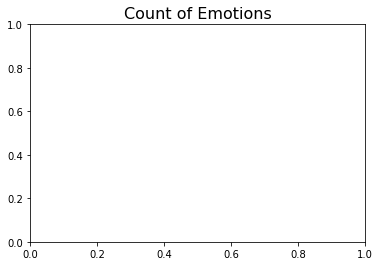

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(train_df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_features(df):
  for index in range(100):

    df[f'feature_{index}'] = 0

    for element, i in zip(df['audio'], range(len(df))):

      df[f'feature_{index}'].iloc[i] = element[index]    
  df = df.drop('audio', axis=1)
  print("features created")

  return df

In [ ]:
train_df = create_features(dataframes['train'])
test_df = create_features(dataframes['test'])
val_df = create_features(dataframes['val'])
clear_output(wait=False)

In [ ]:
print(train_df['label'].unique())

NameError: ignored

In [ ]:
train = train_df.values
test = test_df.values
val = val_df.values

In [ ]:
print(train.shape, test.shape, val.shape)

(5144, 101) (1556, 101) (738, 101)


In [ ]:
X_train, y_train = (np.max(train[:,1:])-train[:,1:])/(np.max(train[:,1:])-np.min(train[:,1:])), train[:,0]
X_test, y_test = (np.max(test[:,1:])-test[:,1:])/(np.max(test[:,1:])-np.min(test[:,1:])), test[:,0]
X_val, y_val = (np.max(val[:,1:])-val[:,1:])/(np.max(val[:,1:])-np.min(val[:,1:])), val[:,0]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(5144, 100) (5144,)
(1556, 100) (1556,)
(738, 100) (738,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train))
y_val = to_categorical(le.fit_transform(y_val))
y_test = to_categorical(le.fit_transform(y_test))
print(y_train.shape)

(5144, 6)


In [ ]:
model = Sequential()
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#Fit Model
cnnhistory=model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
161/161 [==============================] - 1s 3ms/step - loss: 1.7903 - accuracy: 0.1664 - val_loss: 1.7903 - val_accuracy: 0.1748
Epoch 2/5
161/161 [==============================] - 1s 3ms/step - loss: 1.7909 - accuracy: 0.1619 - val_loss: 1.7903 - val_accuracy: 0.1748
Epoch 3/5
161/161 [==============================] - 1s 3ms/step - loss: 1.7904 - accuracy: 0.1643 - val_loss: 1.7904 - val_accuracy: 0.1707
Epoch 4/5
161/161 [==============================] - 1s 3ms/step - loss: 1.7903 - accuracy: 0.1676 - val_loss: 1.7906 - val_accuracy: 0.1707
Epoch 5/5
161/161 [==============================] - 1s 3ms/step - loss: 1.7903 - accuracy: 0.1685 - val_loss: 1.7905 - val_accuracy: 0.1789


In [ ]:
model.predict(X_test)

49/49 [==============================] - 0s 2ms/step


array([[0.14594886, 0.1721653 , 0.16587533, 0.17403477, 0.1676314 ,
        0.17434438],
       [0.1460282 , 0.17194848, 0.1660692 , 0.17395741, 0.16770369,
        0.17429298],
       [0.1461448 , 0.1716225 , 0.16634282, 0.17385282, 0.16780046,
        0.17423663],
       ...,
       [0.14625426, 0.17133926, 0.16657867, 0.17376763, 0.16787453,
        0.1741857 ],
       [0.1459992 , 0.17202775, 0.1659983 , 0.17398572, 0.16767727,
        0.17431179],
       [0.14588478, 0.17234035, 0.16571899, 0.17409715, 0.16757299,
        0.17438576]], dtype=float32)

In [ ]:
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]
print(accuracy)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               25856     
                                                                 
 activation_15 (Activation)  (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 6)                 1542      
                                                                 
 activation_17 (Activation)  (None, 6)                 0         
                                                                 
Total params: 93,190
Trainable params: 93,190
Non-trai